In [52]:
using GynC, Distributions, Sundials, Plots, KernelDensity


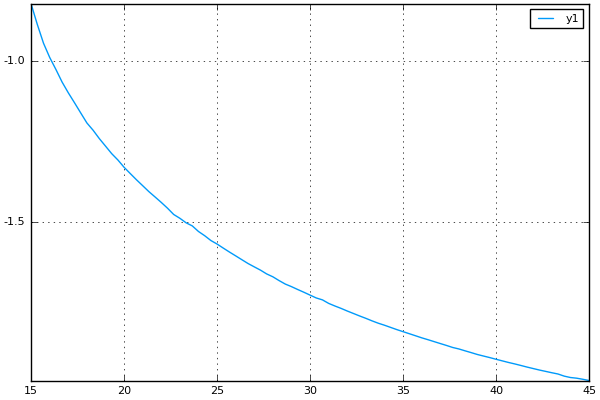

In [53]:
function fitzfn(tau)
  a = .7
  b = .8
  r = tau  
  I = .5

  function fitzhughnagumo(t,y,dy)
    v = y[1]
    w = y[2]
    dy[1] = v - v^3/3 - w + I
    dy[2] = (v + a - b*w) / r
  end
end

phi(tau) =  Sundials.cvode(fitzfn(tau), [1.,0.1], [0,40.])[2,1]
let xs = 15:1/3:45
  plot(xs,[phi(tau) for tau in xs])
end


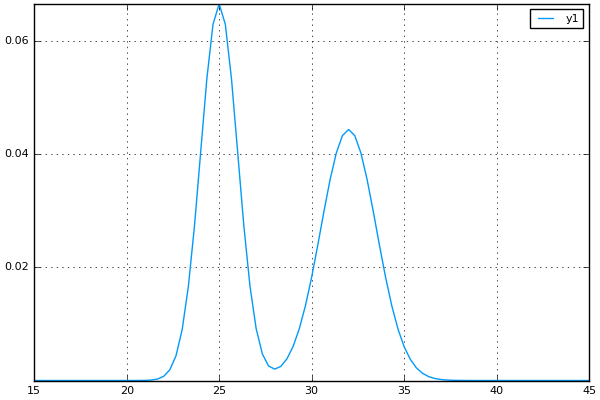

In [54]:
function mixtureprior(xs)
  prior = MixtureModel([Normal(25,1), Normal(32,1.5)])
  wprior = pdf(prior, xs)
  wprior = wprior / sum(wprior);
    
  prior, wprior
end

let xs = 15:1/3:45
    plot(xs, mixtureprior(xs)[2])
end

In [7]:
function performance()
lls = map(w->GynC.logl(m,w), wl)
hzs = map(w->GynC.hz(m,w), we) 
pll = map(w->GynC.hz(m,w) * 0.1 + 0.9 * GynC.logl(m,w), w) 

owds  = map(w->GynC.logl(m,w), wds)
owds2 = map(w->GynC.logl(m,w), wds2)

plot(plot(lls), plot(hzs), plot(pll), plot(owds2), plot(owds))
end

t (generic function with 1 method)

In [5]:
function syntethiclikelihoodmodel(xs, phi, prior::Distribution, ndata, zmult, measerr)
  ys = phi.(xs)
  zs = repmat(ys, zmult) + rand(measerr, length(ys)*zmult)
  datas = phi.(rand(prior, ndata)) + rand(measerr, ndata)
  GynC.LikelihoodModel(xs, ys, zs, datas, measerr)
end

syntethiclikelihoodmodel (generic function with 1 method)

In [6]:
function dslikelihoodmodel(m::GynC.LikelihoodModel, dmult, sigmak)
  sdatas = repmat(m.datas, dmult) + rand(Normal(0,sigmak), length(m.datas) * dmult);
  smeaserr = Normal(0, sqrt(m.measerr.σ^2 + sigmak^2))
  ms = GynC.LikelihoodModel(m.xs, m.ys, m.zs, sdatas, smeaserr, m.zsampledistr)
end

dslikelihoodmodel (generic function with 1 method)

In [7]:
using Interact
function plotws(xs, wsd, n; kwargs...)
    p = plot(title=n; kwargs...)
    for (label, ws) in wsd
        w = ws[n]
        plot!(p, xs, w, label=label, linewidth=2)
    end
    p
end

plotws (generic function with 1 method)

In [8]:
xs = 15:1/10:45

ndata = 30
daugm = 100
zmult = 100

measerr = Normal(0, 0.1)

srand(8)


prior, wprior = mixtureprior(xs)

# default model  
m = syntethiclikelihoodmodel(xs, phi, prior, ndata, zmult, measerr);

# inflated model
@show sigmadata = KernelDensity.default_bandwidth(m.datas)
ms = dslikelihoodmodel(m, daugm, sigmadata);

# initial condition
w0 = ones(length(xs)) / length(xs);

sigmadata = KernelDensity.default_bandwidth(m.datas) = 0.0662359734282005


In [9]:
niter = 200
h = 1

ws = Dict()
@time ws["NPMLE"] = GynC.em(m, w0, niter)
@time ws["DS-MLE"] = GynC.em(ms, w0, niter);

INFO: computing likelihood matrix (301x30)


  4.278856 seconds (3.70 M allocations: 158.901 MB, 6.33% gc time)


INFO: computing likelihood matrix (301x3000)


  2.272320 seconds (1.27 k allocations: 5.108 MB)


In [10]:
#@time ws[:npmle] = GynC.mple(m, w0, niter, 0, h)
@time ws["MPLE"]  = GynC.mple(m, w0, niter, .9, h)
@time ws["Reference Prior"] = GynC.mple(m, w0, niter, 1, h)
#@time ws[:dsmle] = GynC.mple(ms, w0, niter, 0, 1);

INFO: computing likelihood matrix (30100x301)
INFO: computing likelihood matrix (30x301)


 19.123476 seconds (1.73 M allocations: 220.025 MB, 0.93% gc time)
 16.950954 seconds (468.60 k allocations: 150.328 MB, 0.26% gc time)


Interact.Textbox{Int64}(Signal{Int64}(200, nactions=0),"n",nothing,200)


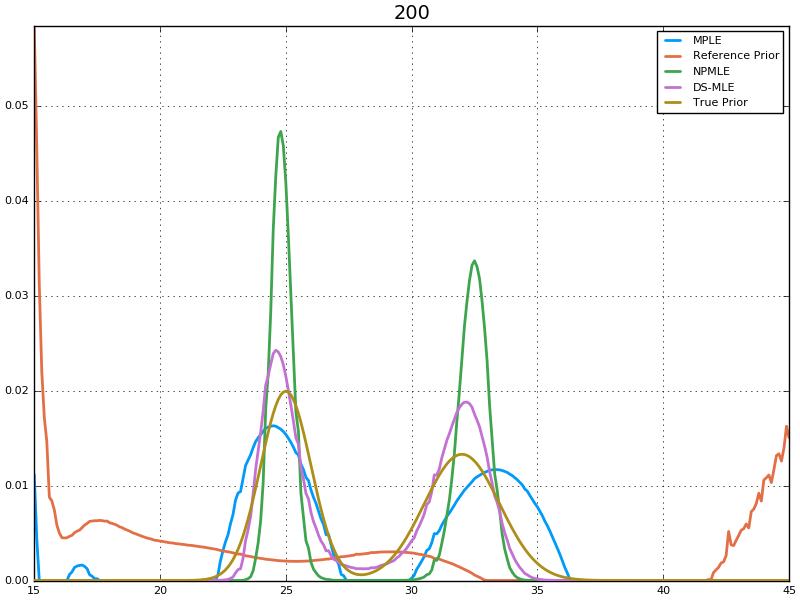

In [11]:
@manipulate for n = niter
    plotws(xs, ws, n, size=(800,600), linesize=30)
    plot!(xs, wprior, label="True Prior", linewidth=2)
end


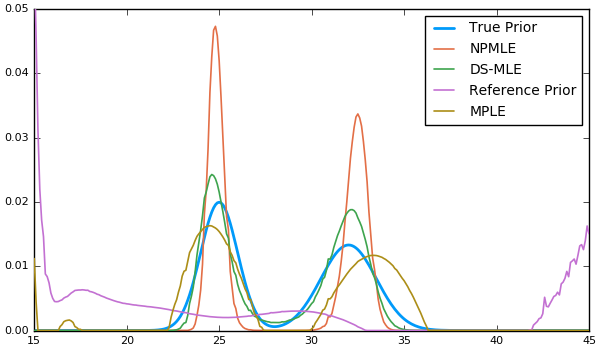

In [56]:
pyplot()
labels = ["NPMLE" "DS-MLE" "Reference Prior" "MPLE"]
densities = map(l->ws[l][end], labels) |> vec
plot(xs, wprior, label="True Prior", linewidth=2, legendfont=font(10), tickfont=font(8), ylims=(0,0.05), size=(600, 350), grid=false)
plot!(xs, densities, labels=labels, linewidth=1.2)
#savefig("fitznagumo2.pdf")

In [57]:
savefig("fitznagumo.pdf")